In [1]:
import numpy as np
import pandas as pd
from scipy import integrate
from scipy.stats import multivariate_normal
from scipy.stats import tmean, tstd
from scipy.stats import norm
from sklearn.utils import resample

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import cnames
from matplotlib import animation
from IPython.display import HTML

from pyDOE import *
import gpflow as gp
from scipy.spatial import distance_matrix

plt.style.use('seaborn-darkgrid')
#sns.set()
sns.set_context("talk")
%matplotlib inline

In [2]:
import sys
sys.path.append('/Users/agarbuno/postdoc/python/modules/ipuq/')

In [3]:
%load_ext autoreload
%autoreload 2
from ces.utils import *

In [4]:
from ces.enka import *

<a id='contents'></a> 
# Table of contents

1. **[Calibrate](#calibrate)**  
2. **[Emulate](#emulate)**  
    **2.1. Linear prior**  
    2.1.2 [All components](#linear-emulate-all)  
    2.1.2 [Non-Centered](#linear-emulate-easy)  
    **2.2. Mixed prior**  
    2.2.2 [All components](#mixed-emulate-all)  
    2.2.2 [Non-Centered](#mixed-emulate-easy)  
    **2.3 [Time variability](#time-var)**  
    **2.4 [Parameter variability](#par-var)**
3. **[Sample](#sample)**


<a id='calibrate'></a> 
#  Calibrate

[go back](#contents)

In [5]:
T = 60.                                 # Final time
dt = 100.                               # Timesteps in each unit
steps = int(T * dt)                     # Overall number of steps
t = np.linspace(0, T, steps + 1)        # time array

T_roll = 10
T_spinup = 30

w0 = (1., 1., 1.)                       # Initial conditions

In [6]:
model = lorenz63()
model.l_window = T_roll
model.freq     = dt

In [7]:
ws = model.solve(w0, t)
y  = model.statistics(ws)

In [8]:
n_obs = 9                               # number of observations
ustar = np.array([[28.], [8./3]])      # true parameters
p = 2                                   # parameter dimensionality

# Generate data
np.random.seed(1)
ws = integrate.odeint(lorenz2d, w0, t, args = (28., 8./3))
xs, ys, zs = ws[:,0], ws[:,1], ws[:,2]
ws = [xs, ys, zs, xs**2, ys**2, zs**2, xs*ys, xs*zs, ys*zs]

# Compute the means of windows of size 10. 
# Allow for a spinup of 30 units of time and gather results
wt = np.asarray([xs[-1], ys[-1], zs[-1]])
gs = [np.asarray(pd.Series(k).rolling(window = int(T_roll * dt)).mean()) for k in ws]
Gamma = np.cov(np.asarray(gs)[:,t>T_spinup])
y_obs = np.asarray(gs)[:,-1]

In [9]:
Jnoise = np.linalg.cholesky(Gamma)
J      = 50

T_eks     = 60
steps_eks = int(T_eks * dt)                     
t_eks     = np.linspace(0, T_eks, steps_eks + 1)

enki = flow(p = p, n_obs = n_obs, J = J)
enki.ustar    = ustar
enki.T        = 100
enki.sigma    = 10.
enki.mu       = 0.0 * np.array([1., 1.]).reshape(2,-1)

np.random.seed(1)
U0 = np.random.uniform(1,30, [enki.p, enki.J])

In [10]:
enki.run_pde(y, U0, wt, t_eks, model, Gamma, Jnoise)

 25%|██▌       | 25/100 [00:16<00:56,  1.33it/s]

In [11]:
# b \in [2, 4]
r_lo = 25.
r_up = 30.

# b \in [2, 4]
b_lo = 2.
b_up = 4.

# # b \in [2, 4]
# r_lo = 27.65
# r_up = 28.45

# # b \in [2, 4]
# b_lo = 2.55
# b_up = 2.85

grid_size = 60
rs, bs = np.meshgrid(np.linspace(r_lo, r_up, grid_size),
                   np.linspace(b_lo, b_up, grid_size))

In [12]:
# Gs = enki.Gpar_pde(np.vstack([np.array([rs.flatten(), bs.flatten()]), 
#                               np.tile(w0, grid_size**2).reshape(grid_size**2, p+1).T]), 
#                    lorenz2d, t)

In [13]:
# fig, axes = plt.subplots(3,3,figsize=(15, 10))
# cmap = plt.get_cmap('gray')

# for ii, ax in enumerate(axes.flatten()):
#     im = ax.contourf(bs, rs,
#                 Gs[ii].reshape(grid_size, grid_size), 5, cmap = cmap)
#     plt.colorbar(im, cmap = cmap, ax= ax, aspect = 10)

    
# plt.suptitle('Components of the forward model. Same initial conditions and integration time.', fontsize = 25);
# fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [14]:
# Phi = ((Gs[:n_obs,:] - y_obs[:,np.newaxis]) * np.linalg.solve(2 * Gamma, Gs[:n_obs,:] - y_obs[:,np.newaxis])).sum(axis = 0)

# fig, ax = plt.subplots(1,1,figsize=(15, 8));
# cmap = plt.get_cmap('gray')
# plt.contourf(bs, rs, (np.log(Phi.reshape(grid_size, grid_size) + \
#                   1.0 * ((bs-enki.mu[0])**2 + (rs-enki.mu[1])**2)/(2*(enki.sigma**2)))), 
#                       np.linspace(.5, 10.5, 6), cmap = cmap)
# plt.colorbar();

# plt.scatter(enki.Ustar[1], enki.Ustar[0])

# ax.axvline(x = ustar[1], linestyle = '--', color = 'black', linewidth = 4)    
# ax.axhline(y = ustar[0], linestyle = '--', color = 'black', linewidth = 4)

# plt.title('Same initial conditions and integration time.');
# fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [15]:
# Gs = enki.Gpar_pde(np.vstack([np.array([rs.flatten(), bs.flatten()]), 
#                               np.tile(wt, grid_size**2).reshape(grid_size**2, p+1).T]), 
#                    lorenz2d, t_eks)

In [16]:
# fig, axes = plt.subplots(3,3,figsize=(15, 10))
# cmap = plt.get_cmap('gray')

# for ii, ax in enumerate(axes.flatten()):
#     im = ax.contourf(bs, rs,
#                 Gs[ii].reshape(grid_size, grid_size), 5, cmap = cmap)
#     plt.colorbar(im, cmap = cmap, ax= ax, aspect = 10)

    
# plt.suptitle('Components of the forward model. Allow for spinup and same integration time.', fontsize = 25);
# fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [17]:
# Phi = ((Gs[:n_obs,:] - y_obs[:,np.newaxis]) * np.linalg.solve(2 * Gamma, Gs[:n_obs,:] - y_obs[:,np.newaxis])).sum(axis = 0)

# fig, ax = plt.subplots(1,1,figsize=(15, 8));
# cmap = plt.get_cmap('gray')
# plt.contourf(bs, rs, (np.log(Phi.reshape(grid_size, grid_size))), 
#              5, cmap = cmap)
# plt.colorbar();

# plt.scatter(enki.Ustar[1], enki.Ustar[0])

# ax.axvline(x = ustar[1], linestyle = '--', color = 'black', linewidth = 4)    
# ax.axhline(y = ustar[0], linestyle = '--', color = 'black', linewidth = 4)

# plt.title('Allows for spinup and same integration time.');
# fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [18]:
# from matplotlib import ticker, cm

# fig, ax = plt.subplots(1,1,figsize=(15, 8));
# cmap = plt.get_cmap('gray')
# cf = plt.contourf(bs, rs, np.log(Phi.reshape(grid_size, grid_size)), 
#                   10, cmap = cmap)
# ax.set(xlim=(0, 30), ylim=(0, 30))
# fig.colorbar(cf, ax=ax)
# ax.axvline(x = ustar[1], linestyle = '--', color = 'black', linewidth = 4)    
# ax.axhline(y = ustar[0], linestyle = '--', color = 'black', linewidth = 4)

# scat = []
# scat.append(ax.scatter([],[])) ;

# #title = ax[0].text(0.5,1., "", bbox={'facecolor':'w', 'alpha':0.5, 'pad':5},
# #                transform=ax.transAxes, ha="center", fontsize = 15)

# def animate(i):
#     scat[0].set_offsets(np.c_[enki.Uall[i,1,:], enki.Uall[i,0,:]]);

# plt.close()

# anim = animation.FuncAnimation(fig, animate, frames = range(len(enki.Uall)))
# HTML(anim.to_html5_video())

In [19]:
# np.random.seed(1)
Gs = enki.Gpar_pde(np.vstack([np.array([rs.flatten(), bs.flatten()]), 
                              np.asarray(ws)[:3][:,np.random.choice(6001,3600,replace=True)]]), 
                   model, t_eks)

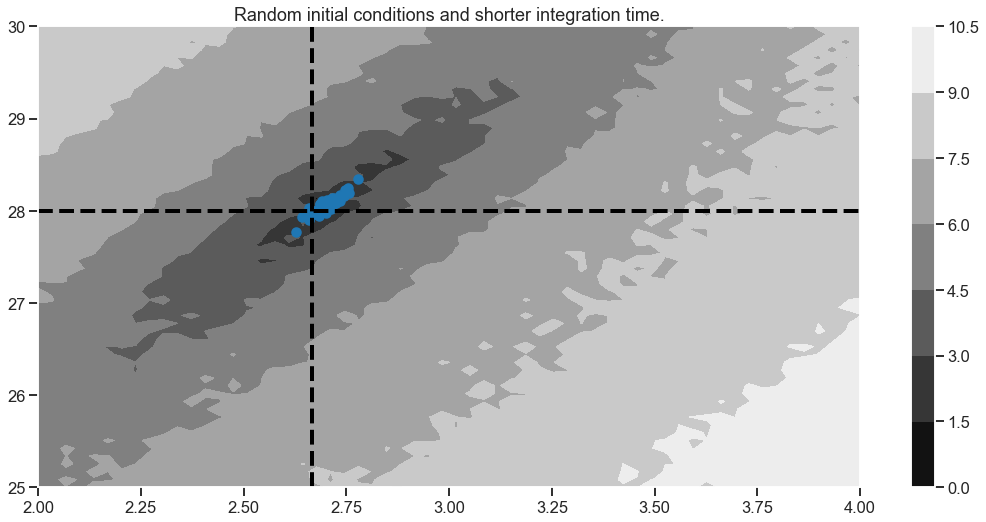

In [20]:
Phi = ((Gs[:n_obs,:] - y_obs[:,np.newaxis]) * np.linalg.solve(2 * Gamma, Gs[:n_obs,:] - y_obs[:,np.newaxis])).sum(axis = 0)

fig, ax = plt.subplots(1,1,figsize=(15, 8));
cmap = plt.get_cmap('gray')
plt.contourf(bs, rs, (np.log(Phi.reshape(grid_size, grid_size))), 
             5, cmap = cmap)
plt.colorbar();

plt.scatter(enki.Ustar[1], enki.Ustar[0])

ax.axvline(x = ustar[1], linestyle = '--', color = 'black', linewidth = 4)    
ax.axhline(y = ustar[0], linestyle = '--', color = 'black', linewidth = 4)

plt.title('Random initial conditions and shorter integration time.');
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

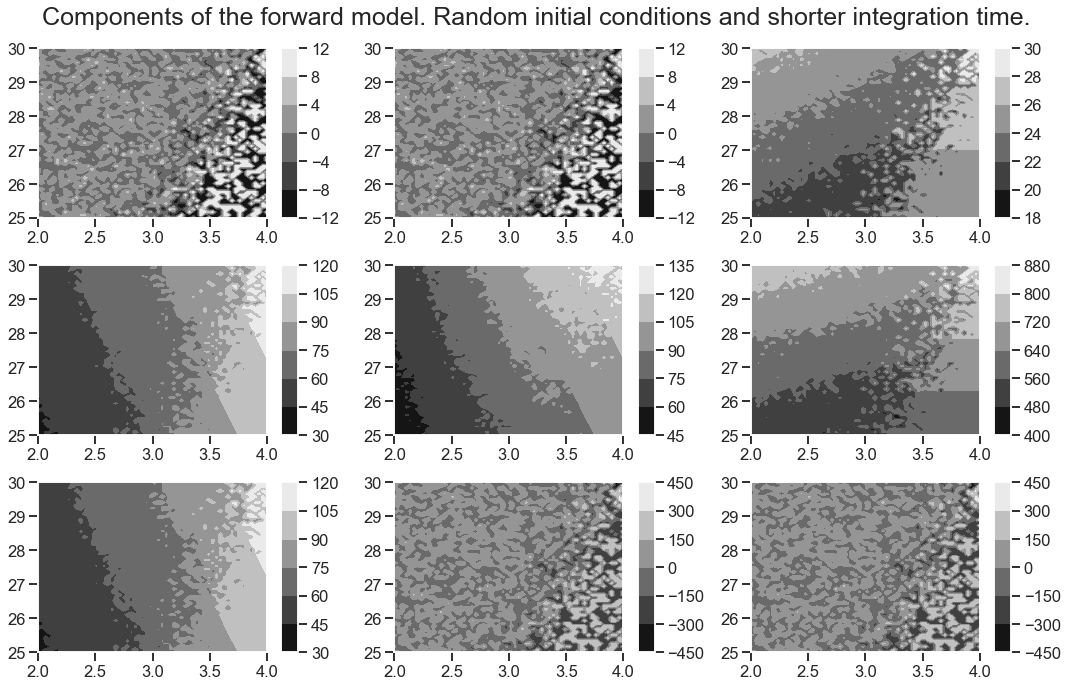

In [21]:
fig, axes = plt.subplots(3,3,figsize=(15, 10))
cmap = plt.get_cmap('gray')

for ii, ax in enumerate(axes.flatten()):
    im = ax.contourf(bs, rs,
                Gs[ii].reshape(grid_size, grid_size), 5, cmap = cmap)
    plt.colorbar(im, cmap = cmap, ax= ax, aspect = 10)


plt.suptitle('Components of the forward model. Random initial conditions and shorter integration time.', fontsize = 25);
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

<a id='emulate'></a>
# 2. Emulate
[go back](#contents)

<a id='linear-emulate-all'></a>
## 2.1.1 Linear mean prior for all components

In [22]:
def emulate(enki):
    enki.gpmodels = []

    for ii, y in enumerate(enki.Gstar[range(enki.n_obs)]):
        with gp.defer_build():
            k = gp.kernels.Matern52(input_dim = enki.p, ARD = True)
            #k = gp.kernels.Polynomial(degree = 2., input_dim = self.p, ARD = True)
            m0 = gp.mean_functions.Linear([[1.],[1.]])
            # m0 = gp.mean_functions.Constant()
            m = gp.models.GPR(enki.Ustar.T, y[:,np.newaxis], k, m0)

            # This prior is good for data in a 2 units scale.
            #m.kern.lengthscales.prior = gp.priors.Gamma(1.4942, 1/5.66074)

            # m.kern.lengthscales.prior = gp.priors.Gamma(1.22449, 1/17.1193)
            # m.kern.lengthscales.prior = gp.priors.Gamma(1.10318, 1/10.7495)
            # m.kern.lengthscales.prior = gp.priors.Gamma( 2.61701, 1./23.245)
            # m.likelihood.variance.trainable = False
            m.likelihood.variance = Gamma[ii,ii]

        m.compile()
        gp.train.ScipyOptimizer().minimize(m);

        enki.gpmodels.append(m)

In [23]:
emulate(enki)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.149682
  Number of iterations: 34
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 100.149682
  Number of iterations: 34
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 100.066551
  Number of iterations: 41
  Number of functions evaluations: 52


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 100.066551
  Number of iterations: 41
  Number of functions evaluations: 52


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 13.587483
  Number of iterations: 51
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 13.587483
  Number of iterations: 51
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 91.734035
  Number of iterations: 39
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 91.734035
  Number of iterations: 39
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.594728
  Number of iterations: 49
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.594728
  Number of iterations: 49
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 193.295629
  Number of iterations: 60
  Number of functions evaluations: 71


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 193.295629
  Number of iterations: 60
  Number of functions evaluations: 71


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 95.146460
  Number of iterations: 40
  Number of functions evaluations: 52


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 95.146460
  Number of iterations: 40
  Number of functions evaluations: 52


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 266.762841
  Number of iterations: 16
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 266.762841
  Number of iterations: 16
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 264.479959
  Number of iterations: 16
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 264.479959
  Number of iterations: 16
  Number of functions evaluations: 22


In [24]:
gpmean, gpvar = enki.gpmodels[0].predict_f(np.vstack([rs.flatten(), bs.flatten()]).T)
gpmean_lambda, gpvar_lambda = enki.gpmodels[0].predict_y(np.vstack([rs.flatten(), bs.flatten()]).T)

(gpvar_lambda - gpvar).mean()

3.2158582761621286

In [25]:
grid_size = 60

gpmeans, gpvars = enki.predict_gps(np.vstack([rs.flatten(), bs.flatten()]).T)

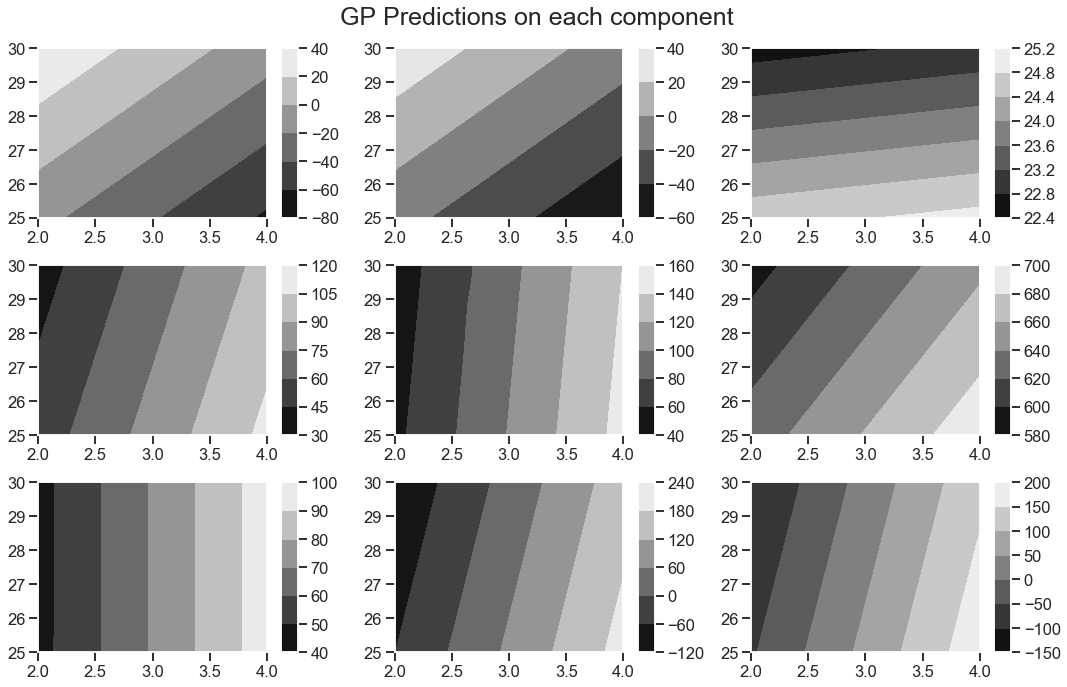

In [26]:
fig, axes = plt.subplots(3,3,figsize=(15, 10))
cmap = plt.get_cmap('gray')

for ii, ax in enumerate(axes.flatten()):
    im = ax.contourf(bs, rs,
                gpmeans[ii].reshape(grid_size, grid_size), 5, cmap = cmap)
    plt.colorbar(im, cmap = cmap, ax= ax, aspect = 10)
    
plt.suptitle('GP Predictions on each component', fontsize = 25);
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [27]:
gplot, varplot = enki.predict_gps(np.vstack([rs.flatten(), bs.flatten()]).T)
gstar, varstar = enki.predict_gps(enki.Ustar.mean(axis = 1).reshape(1, -1))

In [28]:
DGamma = Gamma #- np.diag(np.diag(Gamma))

In [29]:
Hplot = ((gplot - y_obs[:,np.newaxis]) * np.linalg.solve(2 * Gamma, gplot - y_obs[:,np.newaxis])).sum(axis = 0)
Hplot_full = np.empty(shape = Hplot.shape)
Hplot_semi = np.empty(shape = Hplot.shape)

for ii in range(len(varplot.T)):
    Hplot_full[ii] = ((gplot[:,ii] - y_obs) * \
                      np.linalg.solve(2 * (DGamma + np.diag(varplot[:,ii])), gplot[:,ii] - y_obs)).sum() + \
                    0.5 * np.log(np.linalg.det(DGamma + np.diag(varplot[:,ii])))
    Hplot_semi[ii] = ((gplot[:,ii] - y_obs) * \
                      np.linalg.solve(2 * (DGamma + np.diag(varstar.flatten())), gplot[:,ii] - y_obs)).sum() + \
                    0.5 * np.log(np.linalg.det(DGamma + np.diag(varstar.flatten())))

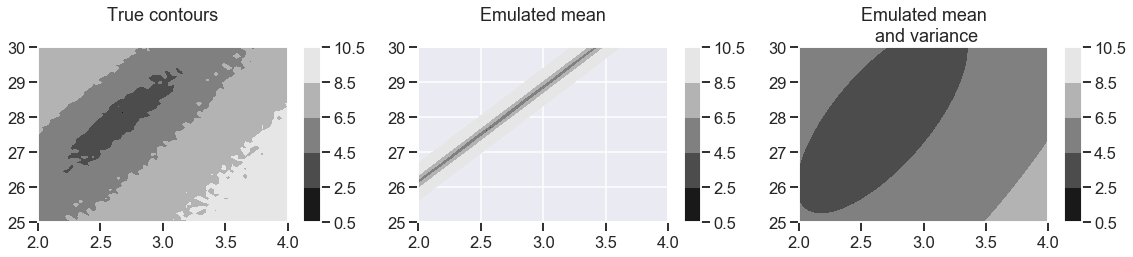

In [30]:
fig, axes = plt.subplots(1,3, figsize = (16, 4));

cmap = plt.get_cmap('gray');
im = axes[0].contourf(bs, rs, np.log(Phi.reshape(grid_size, grid_size) + \
                  1.0 * ((bs-enki.mu[0])**2 + (rs-enki.mu[1])**2)/(2*(enki.sigma**2))), 
                      np.linspace(.5, 10.5, 6), 
                  cmap = cmap);
axes[0].set_title('True contours\n');
plt.colorbar(im, cmap = cmap, ax= axes[0], aspect = 10)

im = axes[1].contourf(bs, rs, np.log(Hplot.reshape(60, 60) + \
                  1.0 * ((bs-enki.mu[0])**2 + (rs-enki.mu[1])**2)/(2*(enki.sigma**2))), 
                      np.linspace(.5, 10.5, 6), 
                  cmap = cmap);
axes[1].set_title('Emulated mean\n');
plt.colorbar(im, cmap = cmap, ax= axes[1], aspect = 10)

im = axes[2].contourf(bs, rs, np.log(Hplot_full.reshape(60, 60) + \
                  1.0 * ((bs-enki.mu[0])**2 + (rs-enki.mu[1])**2)/(2*(enki.sigma**2))), 
                      np.linspace(.5, 10.5, 6), 
                  cmap = cmap);
axes[2].set_title('Emulated mean\n and variance');
plt.colorbar(im, cmap = cmap, ax= axes[2], aspect = 10)

# axes[3].contourf(bs, rs, np.log(Hplot_semi.reshape(60, 60) + \
#                   1.0 * ((bs-enki.mu[0])**2 + (rs-enki.mu[1])**2)/(2*(enki.sigma**2))), 5,
#                   cmap = cmap);
# axes[3].set_title('Emulated mean\n and variance*');

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

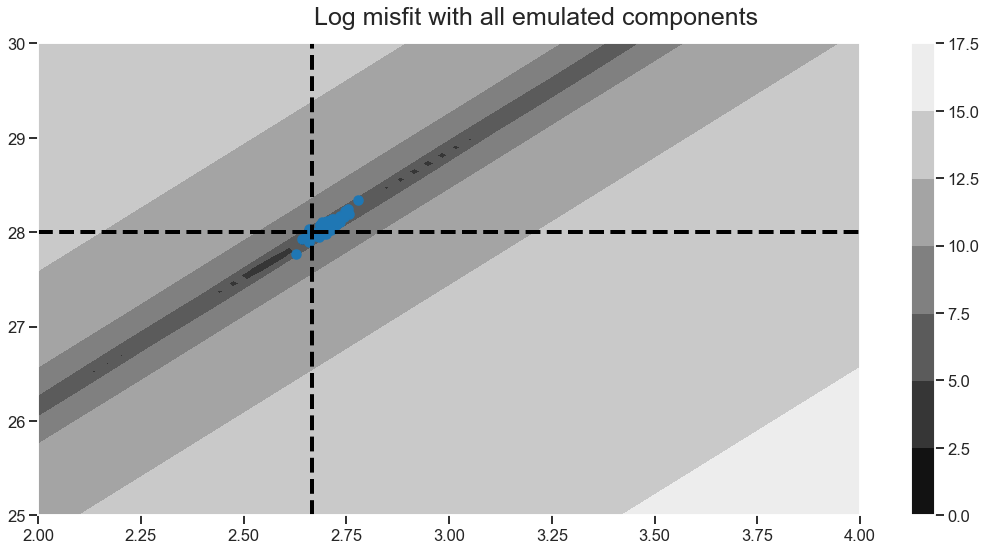

In [31]:
fig, ax = plt.subplots(1,1,figsize=(15, 8));
cmap = plt.get_cmap('gray')
plt.contourf(bs, rs, 
             (np.log(Hplot.reshape(grid_size, grid_size))), 5, cmap = cmap)
plt.colorbar();
plt.suptitle('Log misfit with all emulated components', fontsize = 25);

ax.axvline(x = ustar[1], linestyle = '--', color = 'black', linewidth = 4)    
ax.axhline(y = ustar[0], linestyle = '--', color = 'black', linewidth = 4)


plt.scatter(enki.Ustar[1], enki.Ustar[0])
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

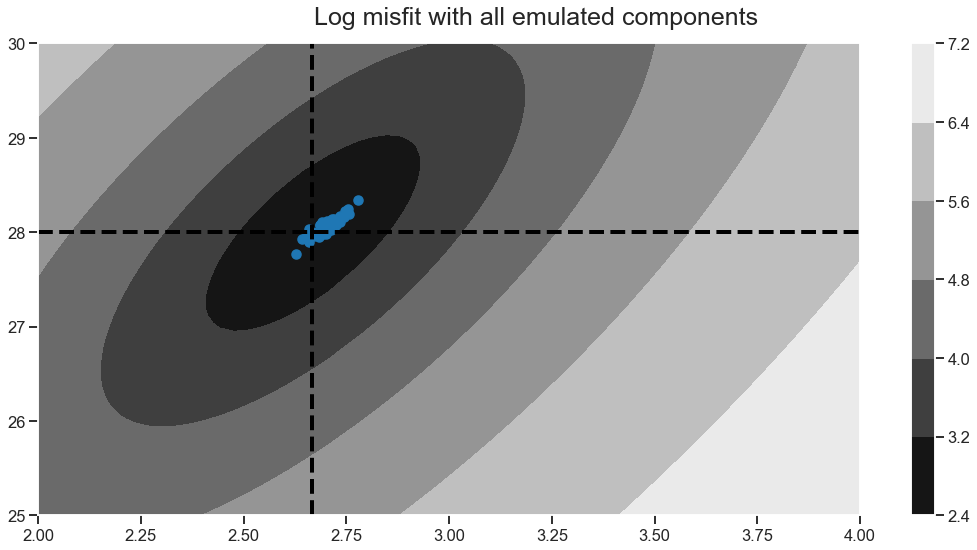

In [32]:
fig, ax = plt.subplots(1,1,figsize=(15, 8));
cmap = plt.get_cmap('gray')
plt.contourf(bs, rs, 
             (np.log(Hplot_full.reshape(grid_size, grid_size))), 5, cmap = cmap)
plt.colorbar();
plt.suptitle('Log misfit with all emulated components', fontsize = 25);

ax.axvline(x = ustar[1], linestyle = '--', color = 'black', linewidth = 4)    
ax.axhline(y = ustar[0], linestyle = '--', color = 'black', linewidth = 4)


plt.scatter(enki.Ustar[1], enki.Ustar[0])
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

<a id='linear-emulate-easy'></a>
# 2.1.2 Learning only the easy components

[go back](#contents)

In [33]:
gplot, varplot = enki.predict_gps(np.vstack([rs.flatten(), bs.flatten()]).T)
gstar, varstar = enki.predict_gps(enki.Ustar.mean(axis = 1).reshape(1, -1))

In [34]:
mask = np.arange(2, 7)

In [35]:
np.log(np.linalg.det(1.0 * Gamma[mask,:][:,mask] + np.diag(varplot[mask,ii])))

8.29340781445193

In [36]:
Hplot = ((gplot[mask,:] - y_obs[mask,np.newaxis]) * np.linalg.solve(2 * Gamma[mask,:][:,mask], gplot[mask,:] - y_obs[mask,np.newaxis])).sum(axis = 0)
Hplot_full = np.empty(shape = Hplot.shape)
Hplot_semi = np.empty(shape = Hplot.shape)

for ii in range(len(varplot.T)):
    Hplot_full[ii] = ((gplot[mask,ii] - y_obs[mask]) * \
                      np.linalg.solve(2 * (DGamma[mask,:][:,mask] + np.diag(varplot[mask,ii])), gplot[mask,ii] - y_obs[mask])).sum() + \
                    0.5 * np.log(np.linalg.det(DGamma[mask,:][:,mask] + np.diag(varplot[mask,ii])))
    Hplot_semi[ii] = ((gplot[mask,ii] - y_obs[mask]) * \
                      np.linalg.solve(2 * (DGamma[mask,:][:,mask] + np.diag(varstar[mask].flatten())), gplot[mask,ii] - y_obs[mask])).sum() + \
                    0.5 * np.log(np.linalg.det(DGamma[mask,:][:,mask] + np.diag(varstar[mask].flatten())))

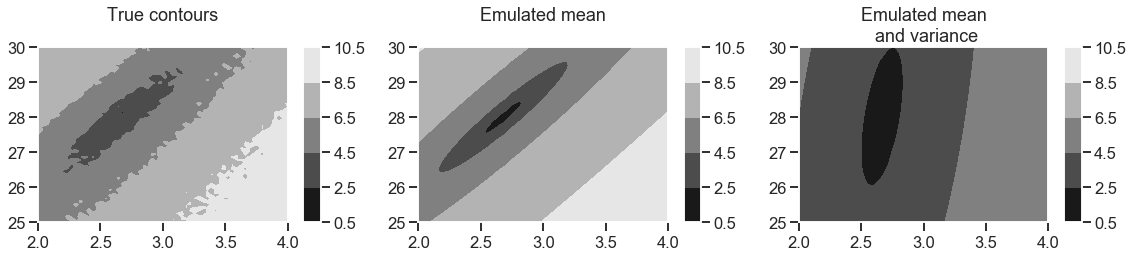

In [37]:
fig, axes = plt.subplots(1,3, figsize = (16, 4));

cmap = plt.get_cmap('gray');
im = axes[0].contourf(bs, rs, np.log(Phi.reshape(grid_size, grid_size) + \
                  1.0 * ((bs-enki.mu[0])**2 + (rs-enki.mu[1])**2)/(2*(enki.sigma**2))), 
                      np.linspace(.5, 10.5, 6), 
                  cmap = cmap);
axes[0].set_title('True contours\n');
plt.colorbar(im, cmap = cmap, ax= axes[0], aspect = 10)

im = axes[1].contourf(bs, rs, np.log(Hplot.reshape(60, 60) + \
                  1.0 * ((bs-enki.mu[0])**2 + (rs-enki.mu[1])**2)/(2*(enki.sigma**2))), 
                      np.linspace(.5, 10.5, 6), 
                  cmap = cmap);
axes[1].set_title('Emulated mean\n');
plt.colorbar(im, cmap = cmap, ax= axes[1], aspect = 10)

im = axes[2].contourf(bs, rs, np.log(Hplot_full.reshape(60, 60) + \
                  1.0 * ((bs-enki.mu[0])**2 + (rs-enki.mu[1])**2)/(2*(enki.sigma**2))), 
                      np.linspace(.5, 10.5, 6), 
                  cmap = cmap);
axes[2].set_title('Emulated mean\n and variance');
plt.colorbar(im, cmap = cmap, ax= axes[2], aspect = 10)

# axes[3].contourf(bs, rs, np.log(Hplot_semi.reshape(60, 60) + \
#                   1.0 * ((bs-enki.mu[0])**2 + (rs-enki.mu[1])**2)/(2*(enki.sigma**2))), 5,
#                   cmap = cmap);
# axes[3].set_title('Emulated mean\n and variance*');

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

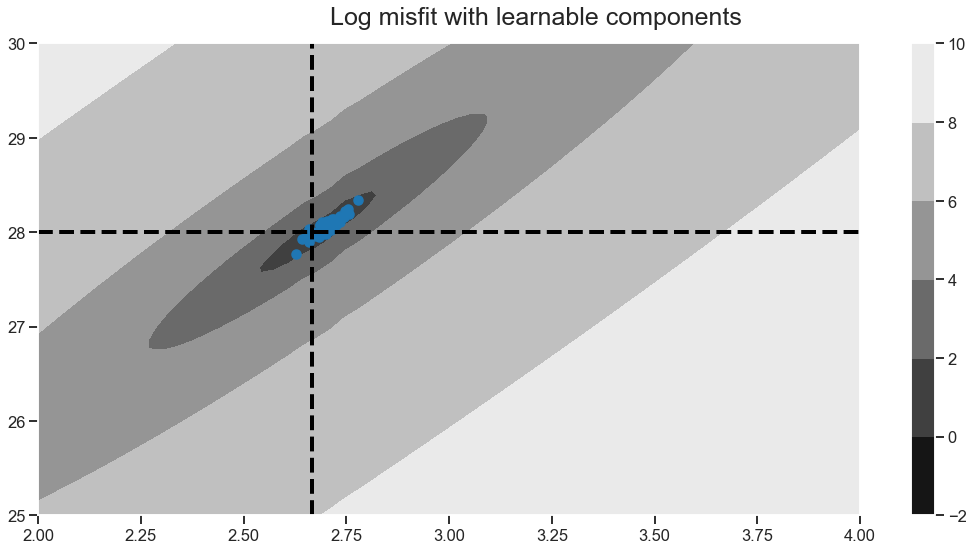

In [38]:
fig, ax = plt.subplots(1,1,figsize=(15, 8));
cmap = plt.get_cmap('gray')
plt.contourf(bs, rs, 
             (np.log(Hplot.reshape(grid_size, grid_size))), 5, cmap = cmap)
plt.colorbar();
plt.suptitle('Log misfit with learnable components', fontsize = 25);

ax.axvline(x = ustar[1], linestyle = '--', color = 'black', linewidth = 4)    
ax.axhline(y = ustar[0], linestyle = '--', color = 'black', linewidth = 4)


plt.scatter(enki.Ustar[1], enki.Ustar[0])
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

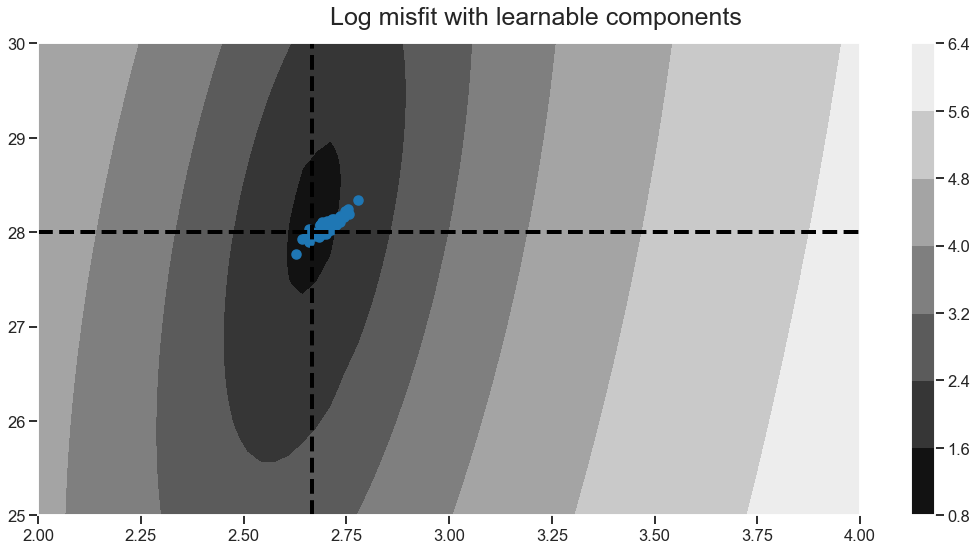

In [39]:
fig, ax = plt.subplots(1,1,figsize=(15, 8));
cmap = plt.get_cmap('gray')
plt.contourf(bs, rs, 
             (np.log(Hplot_full.reshape(grid_size, grid_size))), 5, cmap = cmap)
plt.colorbar();
plt.suptitle('Log misfit with learnable components', fontsize = 25);

ax.axvline(x = ustar[1], linestyle = '--', color = 'black', linewidth = 4)    
ax.axhline(y = ustar[0], linestyle = '--', color = 'black', linewidth = 4)


plt.scatter(enki.Ustar[1], enki.Ustar[0])
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

<a id='mixed-emulate-all'></a>
## 2.2.1 Mixed mean functions
[go back](#contents)

In [40]:
def emulate(enki):
    enki.gpmodels = []

    for ii, y in enumerate(enki.Gstar[range(enki.n_obs)]):
        with gp.defer_build():
            k = gp.kernels.Matern52(input_dim = enki.p, ARD = True)
            #k = gp.kernels.Polynomial(degree = 2., input_dim = self.p, ARD = True)
            if ii in mask: 
                m0 = gp.mean_functions.Linear([[1.],[1.]])
            else: 
                m0 = gp.mean_functions.Constant()       
            m = gp.models.GPR(enki.Ustar.T, y[:,np.newaxis], k, m0)

            # This prior is good for data in a 2 units scale.
            #m.kern.lengthscales.prior = gp.priors.Gamma(1.4942, 1/5.66074)

            # m.kern.lengthscales.prior = gp.priors.Gamma(1.22449, 1/17.1193)
            # m.kern.lengthscales.prior = gp.priors.Gamma(1.10318, 1/10.7495)
            # m.kern.lengthscales.prior = gp.priors.Gamma( 2.61701, 1./23.245)
            # m.likelihood.variance.trainable = False
            m.likelihood.variance = Gamma[ii,ii]

        m.compile()
        gp.train.ScipyOptimizer().minimize(m);

        enki.gpmodels.append(m)

In [41]:
emulate(enki)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.750202
  Number of iterations: 24
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.750202
  Number of iterations: 24
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.390433
  Number of iterations: 23
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.390433
  Number of iterations: 23
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 13.587483
  Number of iterations: 51
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 13.587483
  Number of iterations: 51
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 91.734035
  Number of iterations: 39
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 91.734035
  Number of iterations: 39
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.594728
  Number of iterations: 49
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.594728
  Number of iterations: 49
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 193.295629
  Number of iterations: 60
  Number of functions evaluations: 71


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 193.295629
  Number of iterations: 60
  Number of functions evaluations: 71


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 95.146460
  Number of iterations: 40
  Number of functions evaluations: 52


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 95.146460
  Number of iterations: 40
  Number of functions evaluations: 52


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 266.854914
  Number of iterations: 12
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 266.854914
  Number of iterations: 12
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 264.568420
  Number of iterations: 13
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 264.568420
  Number of iterations: 13
  Number of functions evaluations: 15


In [42]:
grid_size = 60
gpmeans, gpvars = enki.predict_gps(np.vstack([rs.flatten(), bs.flatten()]).T)

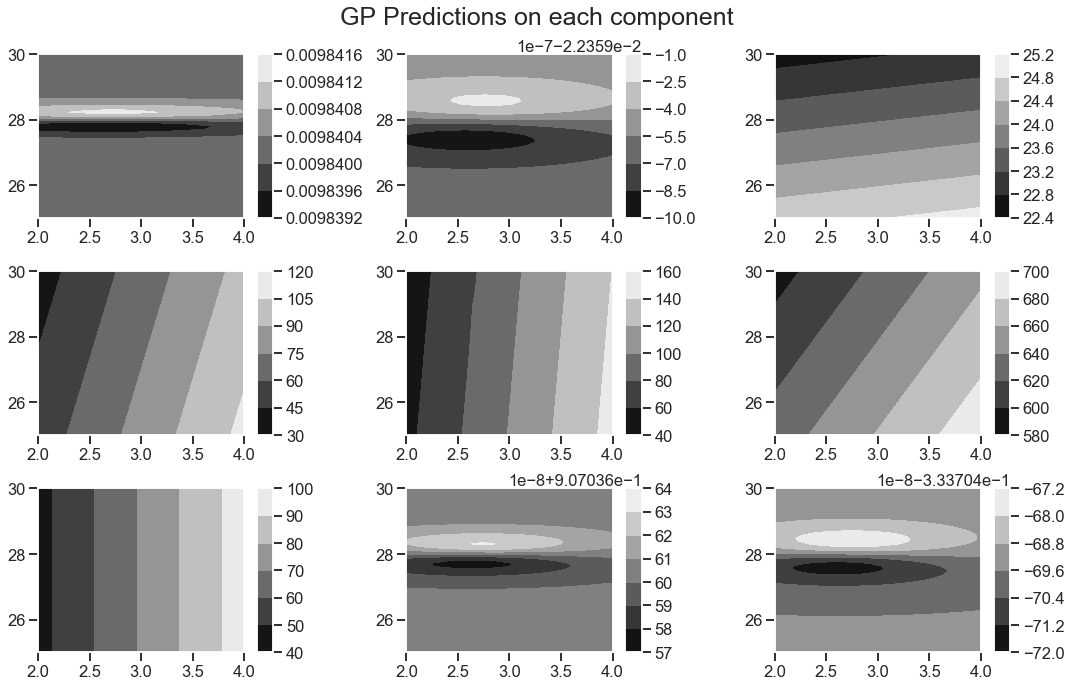

In [43]:
fig, axes = plt.subplots(3,3,figsize=(15, 10))
cmap = plt.get_cmap('gray')

for ii, ax in enumerate(axes.flatten()):
    im = ax.contourf(bs, rs,
                gpmeans[ii].reshape(grid_size, grid_size), 5, cmap = cmap)
    plt.colorbar(im, cmap = cmap, ax= ax, aspect = 10)
    
plt.suptitle('GP Predictions on each component', fontsize = 25);
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [44]:
gplot, varplot = enki.predict_gps(np.vstack([rs.flatten(), bs.flatten()]).T)
gstar, varstar = enki.predict_gps(enki.Ustar.mean(axis = 1).reshape(1, -1))

In [45]:
Hplot = ((gplot - y_obs[:,np.newaxis]) * np.linalg.solve(2 * Gamma, gplot - y_obs[:,np.newaxis])).sum(axis = 0)
Hplot_full = np.empty(shape = Hplot.shape)
Hplot_semi = np.empty(shape = Hplot.shape)

for ii in range(len(varplot.T)):
    Hplot_full[ii] = ((gplot[:,ii] - y_obs) * \
                      np.linalg.solve(2 * (1.0 * DGamma + np.diag(varplot[:,ii])), gplot[:,ii] - y_obs)).sum() + \
                    0.5 * np.log(np.linalg.det(DGamma + np.diag(varplot[:,ii])))
    Hplot_semi[ii] = ((gplot[:,ii] - y_obs) * \
                      np.linalg.solve(2 * (1.0 * DGamma + np.diag(varstar.flatten())), gplot[:,ii] - y_obs)).sum() + \
                    0.5 * np.log(np.linalg.det(DGamma + np.diag(varstar.flatten())))

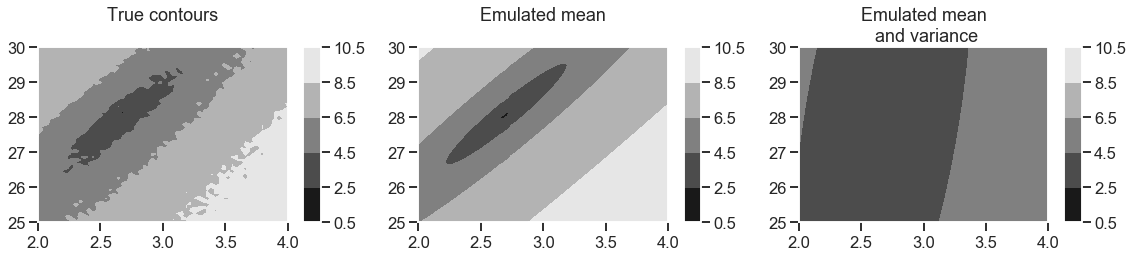

In [46]:
fig, axes = plt.subplots(1,3, figsize = (16, 4));

cmap = plt.get_cmap('gray');
im = axes[0].contourf(bs, rs, np.log(Phi.reshape(grid_size, grid_size) + \
                  1.0 * ((bs-enki.mu[0])**2 + (rs-enki.mu[1])**2)/(2*(enki.sigma**2))), 
                      np.linspace(.5, 10.5, 6), 
                  cmap = cmap);
axes[0].set_title('True contours\n');
plt.colorbar(im, cmap = cmap, ax= axes[0], aspect = 10)

im = axes[1].contourf(bs, rs, np.log(Hplot.reshape(60, 60) + \
                  1.0 * ((bs-enki.mu[0])**2 + (rs-enki.mu[1])**2)/(2*(enki.sigma**2))), 
                      np.linspace(.5, 10.5, 6), 
                  cmap = cmap);
axes[1].set_title('Emulated mean\n');
plt.colorbar(im, cmap = cmap, ax= axes[1], aspect = 10)

im = axes[2].contourf(bs, rs, np.log(Hplot_full.reshape(60, 60) + \
                  1.0 * ((bs-enki.mu[0])**2 + (rs-enki.mu[1])**2)/(2*(enki.sigma**2))), 
                      np.linspace(.5, 10.5, 6), 
                  cmap = cmap);
axes[2].set_title('Emulated mean\n and variance');
plt.colorbar(im, cmap = cmap, ax= axes[2], aspect = 10)

# axes[3].contourf(bs, rs, np.log(Hplot_semi.reshape(60, 60) + \
#                   1.0 * ((bs-enki.mu[0])**2 + (rs-enki.mu[1])**2)/(2*(enki.sigma**2))), 5,
#                   cmap = cmap);
# axes[3].set_title('Emulated mean\n and variance*');

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

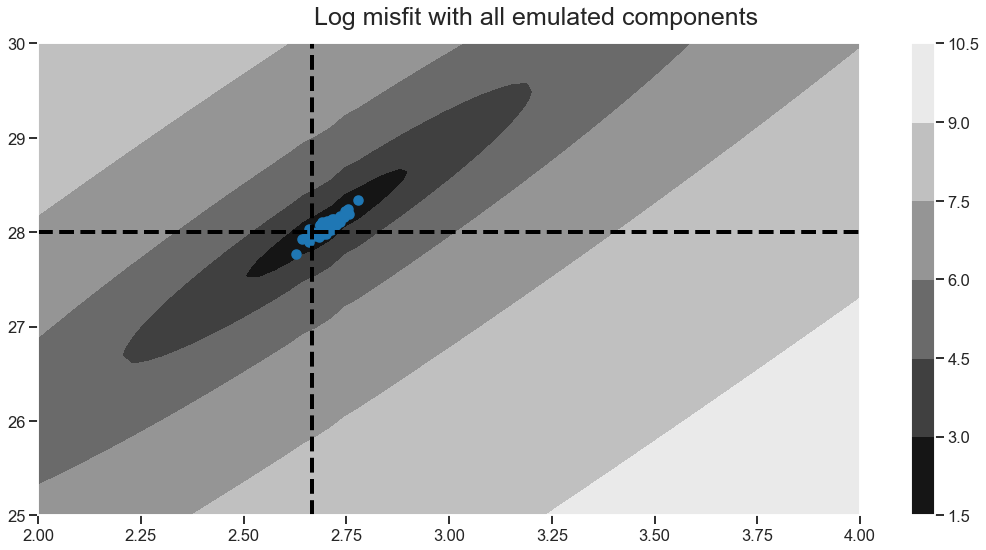

In [47]:
fig, ax = plt.subplots(1,1,figsize=(15, 8));
cmap = plt.get_cmap('gray')
plt.contourf(bs, rs, 
             (np.log(Hplot.reshape(grid_size, grid_size))), 5, cmap = cmap)
plt.colorbar();
plt.suptitle('Log misfit with all emulated components', fontsize = 25);

ax.axvline(x = ustar[1], linestyle = '--', color = 'black', linewidth = 4)    
ax.axhline(y = ustar[0], linestyle = '--', color = 'black', linewidth = 4)


plt.scatter(enki.Ustar[1], enki.Ustar[0])
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

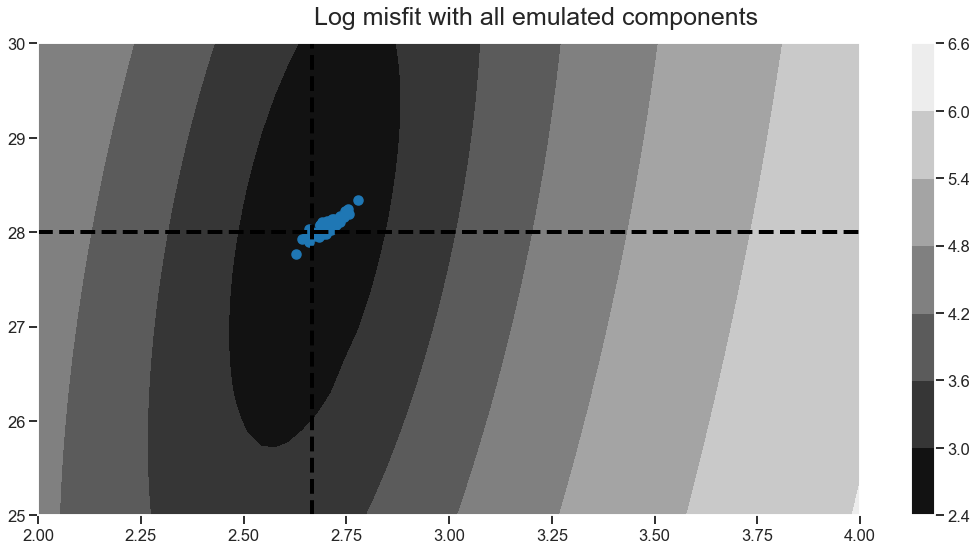

In [48]:
fig, ax = plt.subplots(1,1,figsize=(15, 8));
cmap = plt.get_cmap('gray')
plt.contourf(bs, rs, 
             (np.log(Hplot_full.reshape(grid_size, grid_size))), 5, cmap = cmap)
plt.colorbar();
plt.suptitle('Log misfit with all emulated components', fontsize = 25);

ax.axvline(x = ustar[1], linestyle = '--', color = 'black', linewidth = 4)    
ax.axhline(y = ustar[0], linestyle = '--', color = 'black', linewidth = 4)


plt.scatter(enki.Ustar[1], enki.Ustar[0])
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

<a id='mixed-emulate-easy'></a>
## 2.2.2 Mixed mean functions on easy components
[go back](#contents)

In [49]:
gplot, varplot = enki.predict_gps(np.vstack([rs.flatten(), bs.flatten()]).T)
gstar, varstar = enki.predict_gps(enki.Ustar.mean(axis = 1).reshape(1, -1))

In [50]:
mask = np.arange(2, 7)

In [51]:
np.log(np.linalg.det(1.0 * Gamma[mask,:][:,mask] + np.diag(varplot[mask,ii])))

8.29340781445193

In [52]:
Hplot = ((gplot[mask,:] - y_obs[mask,np.newaxis]) * np.linalg.solve(2 * Gamma[mask,:][:,mask], gplot[mask,:] - y_obs[mask,np.newaxis])).sum(axis = 0)
Hplot_full = np.empty(shape = Hplot.shape)
Hplot_semi = np.empty(shape = Hplot.shape)

for ii in range(len(varplot.T)):
    Hplot_full[ii] = ((gplot[mask,ii] - y_obs[mask]) * \
                      np.linalg.solve(2 * (1.0 * DGamma[mask,:][:,mask] + np.diag(varplot[mask,ii])), gplot[mask,ii] - y_obs[mask])).sum() + \
                    0.5 * np.log(np.linalg.det(1.0 * DGamma[mask,:][:,mask] + np.diag(varplot[mask,ii])))
    Hplot_semi[ii] = ((gplot[mask,ii] - y_obs[mask]) * \
                      np.linalg.solve(2 * (1.0 * DGamma[mask,:][:,mask] + np.diag(varstar[mask].flatten())), gplot[mask,ii] - y_obs[mask])).sum() + \
                    0.5 * np.log(np.linalg.det(1.0 * DGamma[mask,:][:,mask] + np.diag(varstar[mask].flatten())))

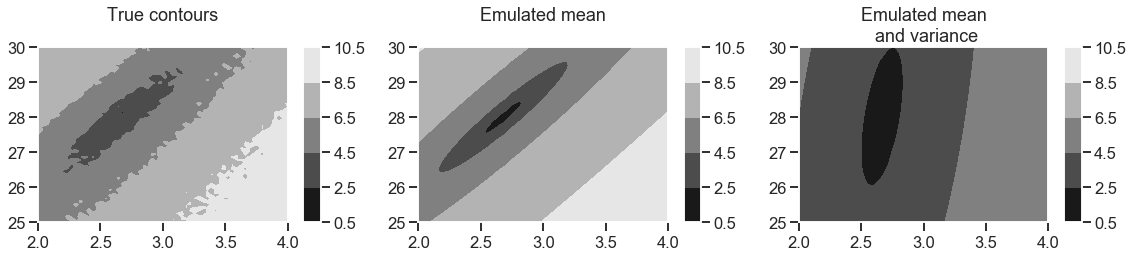

In [53]:
fig, axes = plt.subplots(1,3, figsize = (16, 4));

cmap = plt.get_cmap('gray');
im = axes[0].contourf(bs, rs, np.log(Phi.reshape(grid_size, grid_size) + \
                  1.0 * ((bs-enki.mu[0])**2 + (rs-enki.mu[1])**2)/(2*(enki.sigma**2))), 
                      np.linspace(.5, 10.5, 6), 
                  cmap = cmap);
axes[0].set_title('True contours\n');
plt.colorbar(im, cmap = cmap, ax= axes[0], aspect = 10)

im = axes[1].contourf(bs, rs, np.log(Hplot.reshape(60, 60) + \
                  1.0 * ((bs-enki.mu[0])**2 + (rs-enki.mu[1])**2)/(2*(enki.sigma**2))), 
                      np.linspace(.5, 10.5, 6), 
                  cmap = cmap);
axes[1].set_title('Emulated mean\n');
plt.colorbar(im, cmap = cmap, ax= axes[1], aspect = 10)

im = axes[2].contourf(bs, rs, np.log(Hplot_full.reshape(60, 60) + \
                  1.0 * ((bs-enki.mu[0])**2 + (rs-enki.mu[1])**2)/(2*(enki.sigma**2))),
                      np.linspace(.5, 10.5, 6), 
                  cmap = cmap);
axes[2].set_title('Emulated mean\n and variance');
plt.colorbar(im, cmap = cmap, ax= axes[2], aspect = 10)

# axes[3].contourf(bs, rs, np.log(Hplot_semi.reshape(60, 60) + \
#                   1.0 * ((bs-enki.mu[0])**2 + (rs-enki.mu[1])**2)/(2*(enki.sigma**2))), 5,
#                   cmap = cmap);
# axes[3].set_title('Emulated mean\n and variance*');

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

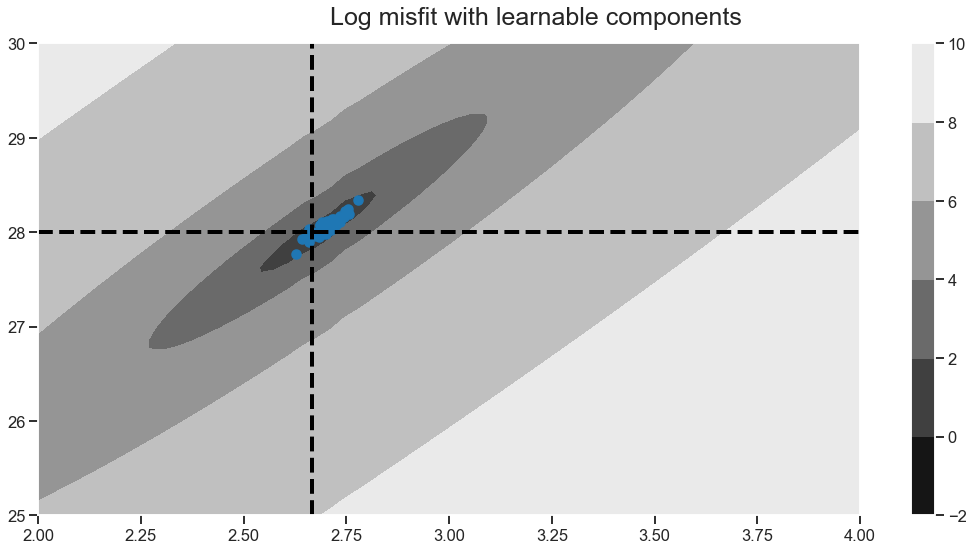

In [54]:
fig, ax = plt.subplots(1,1,figsize=(15, 8));
cmap = plt.get_cmap('gray')
plt.contourf(bs, rs, 
             (np.log(Hplot.reshape(grid_size, grid_size))), 5, cmap = cmap)
plt.colorbar();
plt.suptitle('Log misfit with learnable components', fontsize = 25);

ax.axvline(x = ustar[1], linestyle = '--', color = 'black', linewidth = 4)    
ax.axhline(y = ustar[0], linestyle = '--', color = 'black', linewidth = 4)


plt.scatter(enki.Ustar[1], enki.Ustar[0])
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

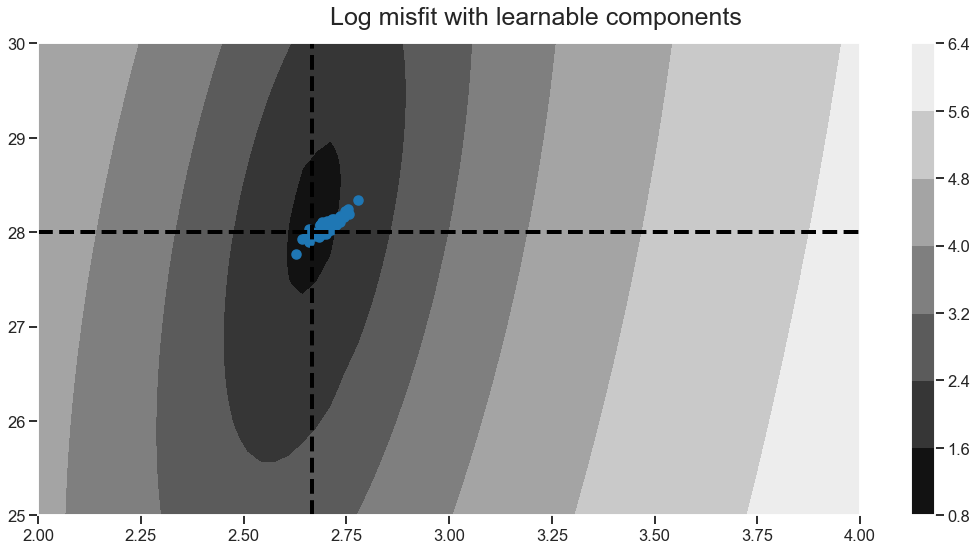

In [55]:
fig, ax = plt.subplots(1,1,figsize=(15, 8));
cmap = plt.get_cmap('gray')
plt.contourf(bs, rs, 
             (np.log(Hplot_full.reshape(grid_size, grid_size))), 5, cmap = cmap)
plt.colorbar();
plt.suptitle('Log misfit with learnable components', fontsize = 25);

ax.axvline(x = ustar[1], linestyle = '--', color = 'black', linewidth = 4)    
ax.axhline(y = ustar[0], linestyle = '--', color = 'black', linewidth = 4)


plt.scatter(enki.Ustar[1], enki.Ustar[0])
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

<a id='time-var'></a>
# 2.3 Time variability diagonalization, wrt: $\Sigma$

From the long time data we can estimate the noise component of the shorter time-average model evaluations, which produces our observation covariance matrix $\Sigma$. We can diagonalize the matrix to obtain 

$$ \Sigma = Q S Q^\top, $$

where all matrices are of comforming sizes. That is, $Q\in \mathbb{R}^{p \times p}$ and $S\in \mathbb{R}^{p \times p }$, where $S$ is an invertible diagonal matrix and $Q$ is an orthogonal matrix.  

Note that every row in this matrix accounts for $G(\theta_j)^\top$ where $j = 1, \ldots, J$. So we can compute the misfit as follows: 

$$
\begin{align}
\|y - G(\theta) \|^2_{\Sigma} = \|y_{q} - G_{q}(\theta) \|^2_{S}, 
\end{align}
$$

where $y_{q} = Q^\top \, y $ and $G_{q}(\theta) = Q^\top \, G(\theta)$

[go back](#contents)

In [56]:
u,d,v = np.linalg.svd(Gamma)

In [57]:
enki.Y = u.T.dot(enki.Gstar)

In [58]:
def emulate(enki):
    enki.gpmodels = []

    for ii, y in enumerate(enki.Y[range(enki.n_obs)]):
        with gp.defer_build():
            k = gp.kernels.Matern52(input_dim = enki.p, ARD = True)
            # k = gp.kernels.Polynomial(degree = 2., input_dim = self.p, ARD = True)
            m0 = gp.mean_functions.Linear([[1.],[1.]])
            # m0 = gp.mean_functions.Constant()
            m = gp.models.GPR(enki.Ustar.T, y[:,np.newaxis], k, m0)

            # This prior is good for data in a 2 units scale.
            #m.kern.lengthscales.prior = gp.priors.Gamma(1.4942, 1/5.66074)

            # m.kern.lengthscales.prior = gp.priors.Gamma(1.22449, 1/17.1193)
            # m.kern.lengthscales.prior = gp.priors.Gamma(1.10318, 1/10.7495)
            # m.kern.lengthscales.prior = gp.priors.Gamma( 2.61701, 1./23.245)
            #m.likelihood.variance.trainable = False
            m.likelihood.variance = d[ii]

        m.compile()
        gp.train.ScipyOptimizer().minimize(m);

        enki.gpmodels.append(m)

In [59]:
emulate(enki)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 281.387411
  Number of iterations: 43
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 281.387411
  Number of iterations: 43
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 194.533652
  Number of iterations: 38
  Number of functions evaluations: 48


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 194.533652
  Number of iterations: 38
  Number of functions evaluations: 48


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 130.623338
  Number of iterations: 31
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 130.623338
  Number of iterations: 31
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.135821
  Number of iterations: 69
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.135821
  Number of iterations: 69
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 56.886336
  Number of iterations: 45
  Number of functions evaluations: 50


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 56.886336
  Number of iterations: 45
  Number of functions evaluations: 50


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -18.817659
  Number of iterations: 39
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -18.817659
  Number of iterations: 39
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -51.945028
  Number of iterations: 128
  Number of functions evaluations: 159


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -51.945028
  Number of iterations: 128
  Number of functions evaluations: 159


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -112.645730
  Number of iterations: 51
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -112.645730
  Number of iterations: 51
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -142.160483
  Number of iterations: 42
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -142.160483
  Number of iterations: 42
  Number of functions evaluations: 66


In [60]:
grid_size = 60
gpmeans, gpvars = enki.predict_gps(np.vstack([rs.flatten(), bs.flatten()]).T)

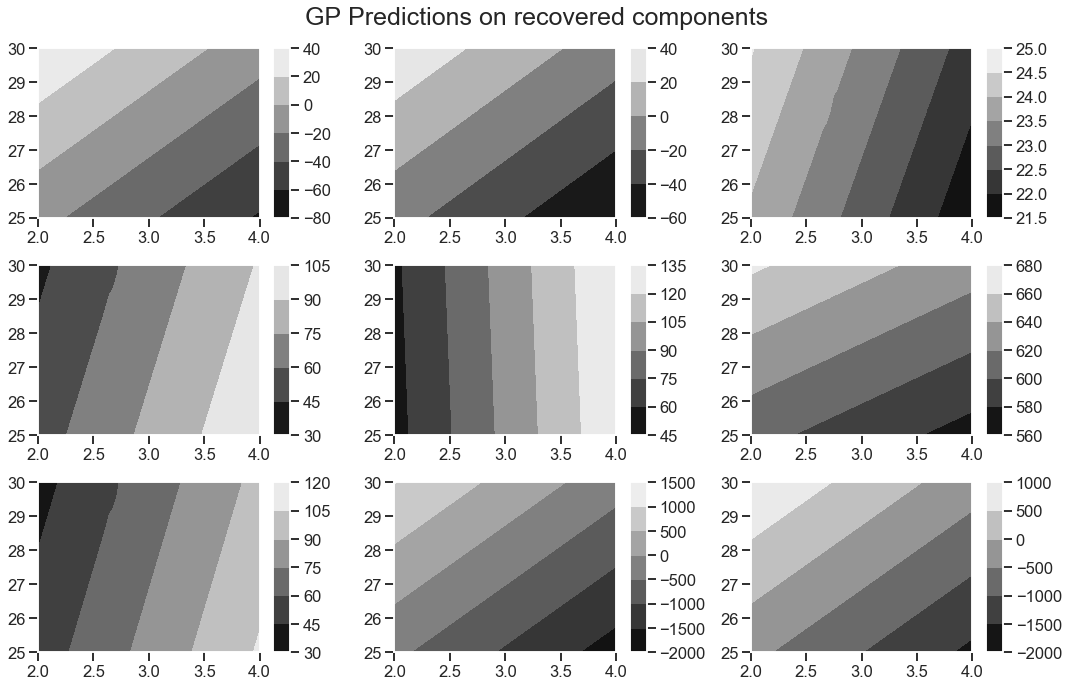

In [61]:
fig, axes = plt.subplots(3,3,figsize=(15, 10))
cmap = plt.get_cmap('gray')

for ii, ax in enumerate(axes.flatten()):
    im = ax.contourf(bs, rs,
                (u.dot(gpmeans)[ii]).reshape(grid_size, grid_size), 5, cmap = cmap)
    plt.colorbar(im, cmap = cmap, ax= ax, aspect = 10)
    
plt.suptitle('GP Predictions on recovered components', fontsize = 25);
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [62]:
# fig, axes = plt.subplots(3,3,figsize=(15, 10))
# cmap = plt.get_cmap('gray')

# for ii, ax in enumerate(axes.flatten()):
#     im = ax.contourf(bs, rs,
#                 gpmeans[ii].reshape(grid_size, grid_size), 5, cmap = cmap)
#     plt.colorbar(im, cmap = cmap, ax= ax, aspect = 10)
    
# plt.suptitle('GP Predictions on each decorrelated component', fontsize = 25);
# fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [63]:
# fig, axes = plt.subplots(3,3,figsize=(15, 10))
# cmap = plt.get_cmap('gray')

# for ii, ax in enumerate(axes.flatten()):
#     im = ax.contourf(bs, rs,
#                 (u.T.dot(Gs[:n_obs]))[ii].reshape(grid_size, grid_size), 5, cmap = cmap)
#     plt.colorbar(im, cmap = cmap, ax= ax, aspect = 10)
    
# plt.suptitle('Decorrelated components of the forward model. Allows for spinup and shorter integration time.', fontsize = 25); 
# fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [64]:
gplot, varplot = enki.predict_gps(np.vstack([rs.flatten(), bs.flatten()]).T)
gstar, varstar = enki.predict_gps(enki.Ustar.mean(axis = 1).reshape(1, -1))

In [65]:
Hplot = ((gplot - u.T.dot(y_obs)[:,np.newaxis]) * \
         np.linalg.solve(2 * np.diag(d), gplot - u.T.dot(y_obs)[:,np.newaxis])).sum(axis = 0)
Hplot_full = np.empty(shape = Hplot.shape)
Hplot_semi = np.empty(shape = Hplot.shape)

for ii in range(len(varplot.T)):
    Hplot_full[ii] = ((gplot[:,ii] - u.T.dot(y_obs)) * \
                      np.linalg.solve(2 * (np.diag(d) + np.diag(varplot[:,ii])), 
                                      gplot[:,ii] - u.T.dot(y_obs))).sum() + \
                    0.5 * np.log(d + varplot[:,ii]).sum()
    Hplot_semi[ii] = ((gplot[:,ii] - u.T.dot(y_obs)) * \
                      np.linalg.solve(2 * (np.diag(d) + np.diag(varstar.flatten())), 
                                      gplot[:,ii] - u.T.dot(y_obs))).sum() + \
                    0.5 * np.log(d + varstar.flatten()).sum()

In [66]:
np.log(d + varplot[:,ii]).sum()
varplot[:,ii]
d

array([4.87958026e+03, 1.18277874e+02, 1.29564988e+01, 5.60797827e+00,
       3.81098330e-01, 3.26319674e-02, 4.85435842e-03, 7.45501582e-04,
       1.96818894e-04])

In [67]:
np.log(np.linalg.det(np.diag(d) + np.diag(varplot[:,ii])))

-1.3265514734151136

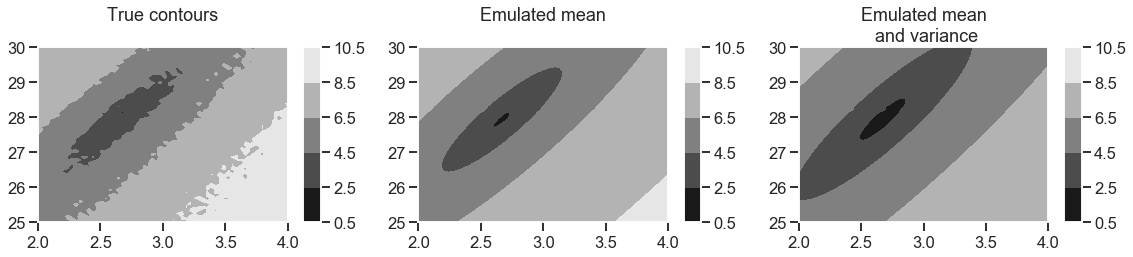

In [68]:
fig, axes = plt.subplots(1,3, figsize = (16, 4));

cmap = plt.get_cmap('gray');
im = axes[0].contourf(bs, rs, np.log(Phi.reshape(grid_size, grid_size) + \
                  1.0 * ((bs-enki.mu[0])**2 + (rs-enki.mu[1])**2)/(2*(enki.sigma**2))), 
                      np.linspace(.5, 10.5, 6), 
                  cmap = cmap);
axes[0].set_title('True contours\n');
plt.colorbar(im, cmap = cmap, ax= axes[0], aspect = 10)

im = axes[1].contourf(bs, rs, np.log(Hplot.reshape(60, 60) + \
                  1.0 * ((bs-enki.mu[0])**2 + (rs-enki.mu[1])**2)/(2*(enki.sigma**2))), 
                      np.linspace(.5, 10.5, 6), 
                  cmap = cmap);
axes[1].set_title('Emulated mean\n');
plt.colorbar(im, cmap = cmap, ax= axes[1], aspect = 10)

im = axes[2].contourf(bs, rs, np.log(Hplot_full.reshape(60, 60) + \
                  1.0 * ((bs-enki.mu[0])**2 + (rs-enki.mu[1])**2)/(2*(enki.sigma**2))), 
                      np.linspace(.5, 10.5, 6),
                  cmap = cmap);
axes[2].set_title('Emulated mean\n and variance');
plt.colorbar(im, cmap = cmap, ax= axes[2], aspect = 10)

# axes[3].contourf(bs, rs, np.log(Hplot_semi.reshape(60, 60) + \
#                   1.0 * ((bs-enki.mu[0])**2 + (rs-enki.mu[1])**2)/(2*(enki.sigma**2))), 5,
#                   cmap = cmap);
# axes[3].set_title('Emulated mean\n and variance*');

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

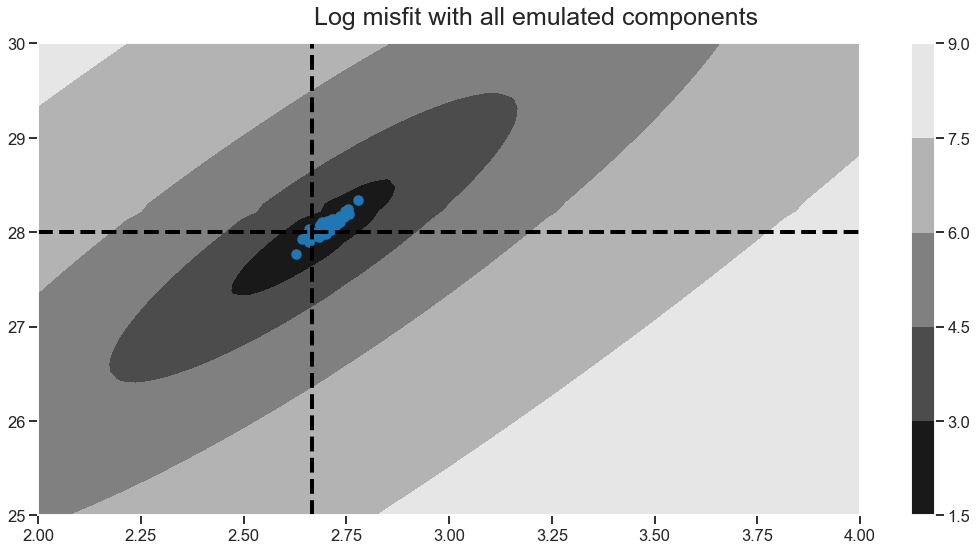

In [69]:
fig, ax = plt.subplots(1,1,figsize=(15, 8));
cmap = plt.get_cmap('gray')
plt.contourf(bs, rs, 
             (np.log(Hplot.reshape(grid_size, grid_size))), 5, cmap = cmap)
plt.colorbar();
plt.suptitle('Log misfit with all emulated components', fontsize = 25);

ax.axvline(x = ustar[1], linestyle = '--', color = 'black', linewidth = 4)    
ax.axhline(y = ustar[0], linestyle = '--', color = 'black', linewidth = 4)

plt.scatter(enki.Ustar[1], enki.Ustar[0])
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

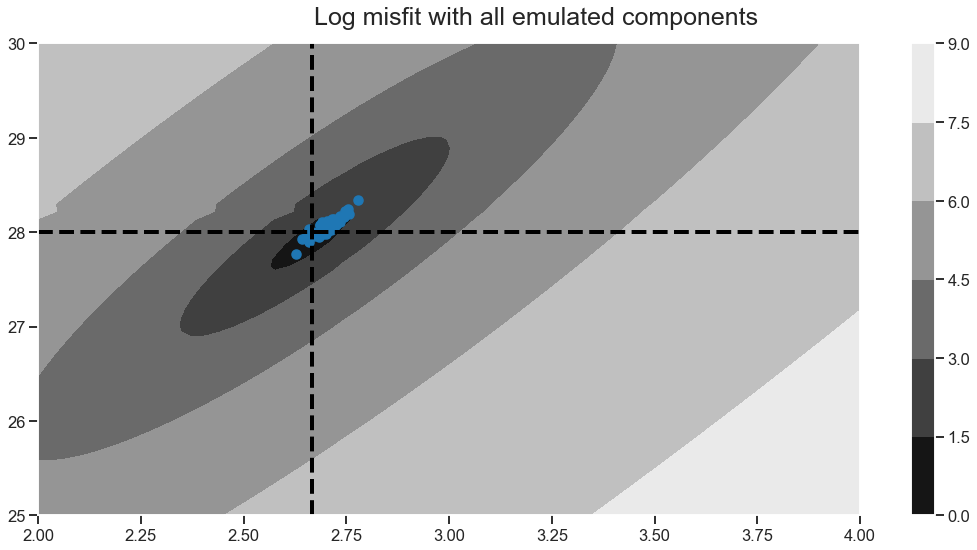

In [70]:
fig, ax = plt.subplots(1,1,figsize=(15, 8));
cmap = plt.get_cmap('gray')
plt.contourf(bs, rs, 
             (np.log(Hplot_full.reshape(grid_size, grid_size))), 5, cmap = cmap)
plt.colorbar();
plt.suptitle('Log misfit with all emulated components', fontsize = 25);

ax.axvline(x = ustar[1], linestyle = '--', color = 'black', linewidth = 4)    
ax.axhline(y = ustar[0], linestyle = '--', color = 'black', linewidth = 4)


plt.scatter(enki.Ustar[1], enki.Ustar[0])
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

<a id='par-var'></a>
# 2.4  Parameter variability

The EKS samples generate a set of training runs for the GP that can be stored in matrix form $G\in \mathbb{R}^{J\times p}$. Diagonalizing this matrix would account for parameter variability. Thus, we can compute an incomplete SVD decomposition of the form 

$$ G = U D V^\top, $$

where all matrices are of comforming sizes. That is, $U\in \mathbb{R}^{J \times p}$ and $D,V \in \mathbb{R}^{p}$, where $D$ is an invertible diagonal matrix and $V$ is an orthogonal matrix.  

Note that every row in this matrix accounts for $G(\theta_j)^\top$ where $j = 1, \ldots, J$. So we can compute the misfit as follows: 

$$
\begin{align}
\|y - G(\theta) \|^2_{\Sigma} = \|y_{VD} - G_{VD}(\theta) \|^2_{D^{-1}V^\top\Sigma V D^{-1}}, 
\end{align}
$$

where $y_{VD} = D^{-1}V^\top \, y $ and $G_{VD}(\theta) = D^{-1}V^\top \, G(\theta)$

[go back](#contents)

In [71]:
u,d,vh = np.linalg.svd(enki.Gstar.T, full_matrices=False)
enki.Y = u.T


In [72]:
def emulate(enki):
    enki.gpmodels = []

    for ii, y in enumerate(enki.Y[range(enki.n_obs)]):
        with gp.defer_build():
            k = gp.kernels.Matern52(input_dim = enki.p, ARD = True)
            # k = gp.kernels.Polynomial(degree = 2., input_dim = self.p, ARD = True)
            m0 = gp.mean_functions.Linear([[1.],[1.]])
            # m0 = gp.mean_functions.Constant()
            m = gp.models.GPR(enki.Ustar.T, y[:,np.newaxis], k, m0)

            # This prior is good for data in a 2 units scale.
            #m.kern.lengthscales.prior = gp.priors.Gamma(1.4942, 1/5.66074)

            # m.kern.lengthscales.prior = gp.priors.Gamma(1.22449, 1/17.1193)
            # m.kern.lengthscales.prior = gp.priors.Gamma(1.10318, 1/10.7495)
            # m.kern.lengthscales.prior = gp.priors.Gamma( 2.61701, 1./23.245)
            # m.likelihood.variance.trainable = False
            # m.likelihood.variance = d[ii]

        m.compile()
        gp.train.ScipyOptimizer().minimize(m);

        enki.gpmodels.append(m)

In [73]:
emulate(enki)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -226.589953
  Number of iterations: 116
  Number of functions evaluations: 157


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -226.589953
  Number of iterations: 116
  Number of functions evaluations: 157


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -28.492206
  Number of iterations: 49
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -28.492206
  Number of iterations: 49
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -30.841041
  Number of iterations: 44
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -30.841041
  Number of iterations: 44
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -29.989146
  Number of iterations: 51
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -29.989146
  Number of iterations: 51
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -28.735758
  Number of iterations: 57
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -28.735758
  Number of iterations: 57
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -30.034741
  Number of iterations: 56
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -30.034741
  Number of iterations: 56
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -32.010160
  Number of iterations: 92
  Number of functions evaluations: 119


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -32.010160
  Number of iterations: 92
  Number of functions evaluations: 119


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -32.413669
  Number of iterations: 72
  Number of functions evaluations: 85


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -32.413669
  Number of iterations: 72
  Number of functions evaluations: 85


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -27.273800
  Number of iterations: 47
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -27.273800
  Number of iterations: 47
  Number of functions evaluations: 65


In [74]:
grid_size = 60
gpmeans, gpvars = enki.predict_gps(np.vstack([rs.flatten(), bs.flatten()]).T)

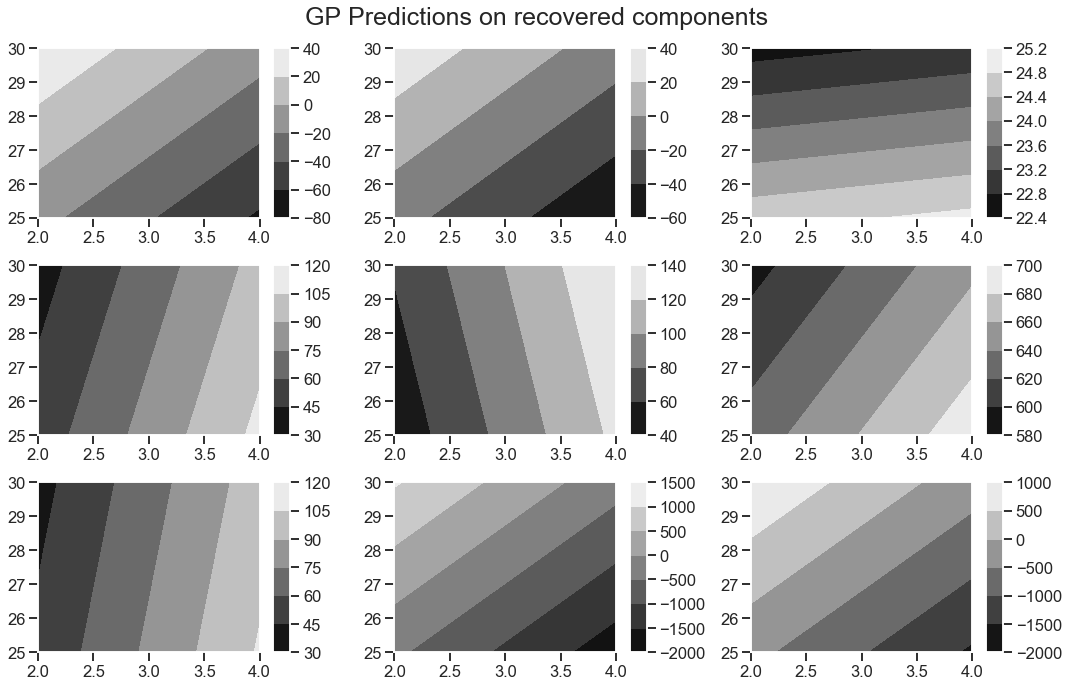

In [75]:
fig, axes = plt.subplots(3,3,figsize=(15, 10))
cmap = plt.get_cmap('gray')

for ii, ax in enumerate(axes.flatten()):
    im = ax.contourf(bs, rs,
                (vh.T.dot(np.diag(d).dot(gpmeans))[ii]).reshape(grid_size, grid_size), 5, cmap = cmap)
    plt.colorbar(im, cmap = cmap, ax= ax, aspect = 10)
    
plt.suptitle('GP Predictions on recovered components', fontsize = 25);
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [76]:
VDh = np.diag(1/d).dot(vh)

In [77]:
d

array([4.53535358e+03, 4.91814929e+02, 2.31678096e+01, 2.22994280e+01,
       7.29006373e+00, 2.00404496e+00, 5.91672712e-01, 3.58901975e-01,
       8.73109258e-02])

In [78]:
# fig, axes = plt.subplots(3,3,figsize=(15, 10))
# cmap = plt.get_cmap('gray')

# for ii, ax in enumerate(axes.flatten()):
#     im = ax.contourf(bs, rs,
#                 (VDh.dot(Gs[:n_obs]))[ii].reshape(grid_size, grid_size), 5, cmap = cmap)
#     plt.colorbar(im, cmap = cmap, ax= ax, aspect = 10)
    
# plt.suptitle('Decorrelated components of the forward model. Allows for spinup and shorter integration time.', fontsize = 25); 
# fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [79]:
gplot, varplot = enki.predict_gps(np.vstack([rs.flatten(), bs.flatten()]).T)
gstar, varstar = enki.predict_gps(enki.Ustar.mean(axis = 1).reshape(1, -1))

In [80]:
DGamma = VDh.dot(Gamma.dot(VDh.T))

In [81]:
Hplot = ((gplot - VDh.dot(y_obs[:,np.newaxis])) * np.linalg.solve(2 * DGamma, gplot - VDh.dot(y_obs[:,np.newaxis]))).sum(axis = 0)
Hplot_full = np.empty(shape = Hplot.shape)
Hplot_semi = np.empty(shape = Hplot.shape)

for ii in range(len(varplot.T)):
    Hplot_full[ii] = ((gplot[:,ii] - VDh.dot(y_obs)) * \
                      np.linalg.solve(2 * (DGamma + np.diag(varplot[:,ii])), gplot[:,ii] - VDh.dot(y_obs))).sum() + \
                    0.5 * np.log(np.linalg.det(DGamma + np.diag(varplot[:,ii])))
    Hplot_semi[ii] = ((gplot[:,ii] - VDh.dot(y_obs)) * \
                      np.linalg.solve(2 * (DGamma + np.diag(varstar.flatten())), gplot[:,ii] - VDh.dot(y_obs))).sum() + \
                    0.5 * np.log(np.linalg.det(DGamma + np.diag(varstar.flatten())))

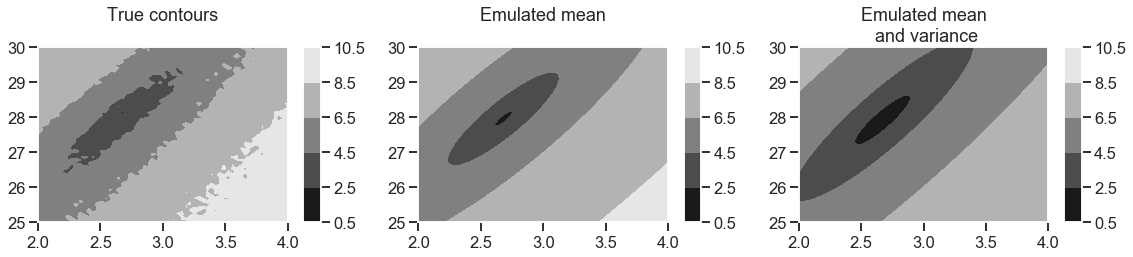

In [82]:
fig, axes = plt.subplots(1,3, figsize = (16, 4));

cmap = plt.get_cmap('gray');
im = axes[0].contourf(bs, rs, np.log(Phi.reshape(grid_size, grid_size) + \
                  1.0 * ((bs-enki.mu[0])**2 + (rs-enki.mu[1])**2)/(2*(enki.sigma**2))), 
                  np.linspace(.5, 10.5, 6),
                  cmap = cmap);
axes[0].set_title('True contours\n');
plt.colorbar(im, cmap = cmap, ax= axes[0], aspect = 10)

im = axes[1].contourf(bs, rs, np.log(Hplot.reshape(60, 60) + \
                  1.0 * ((bs-enki.mu[0])**2 + (rs-enki.mu[1])**2)/(2*(enki.sigma**2))), 
                      np.linspace(.5, 10.5, 6), 
                  cmap = cmap);
axes[1].set_title('Emulated mean\n');
plt.colorbar(im, cmap = cmap, ax= axes[1], aspect = 10)

im = axes[2].contourf(bs, rs, np.log(Hplot_full.reshape(60, 60) + \
                  1.0 * ((bs-enki.mu[0])**2 + (rs-enki.mu[1])**2)/(2*(enki.sigma**2)) - Hplot_full.min()), 
                      np.linspace(.5, 10.5, 6),
                  cmap = cmap);
axes[2].set_title('Emulated mean\n and variance');
plt.colorbar(im, cmap = cmap, ax= axes[2], aspect = 10)

# axes[3].contourf(bs, rs, np.log(Hplot_semi.reshape(60, 60) + \
#                   1.0 * ((bs-enki.mu[0])**2 + (rs-enki.mu[1])**2)/(2*(enki.sigma**2))), 5,
#                   cmap = cmap);
# axes[3].set_title('Emulated mean\n and variance*');

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

[go back](#contents)